In [2]:
import numpy as np # linear algebra
import re, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf

import datetime
from datetime import datetime

# BERT
import sys
sys.path.append('bert-master')
import optimization
import run_classifier
import tokenization
import tensorflow_hub as hub

In [3]:
# Checking tensorflow version (should be 1.15)
tf.__version__

'1.15.0'


## Read the training dataset


In [7]:
# Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = './bbc-fulltext (document classification)/bbc/'  
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

##  Get the data as dataframe


In [8]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df.head()

,text,label
0,Quarterly profits at US media giant TimeWarn...,business
1,The dollar has hit its highest level against...,business
2,The owners of embattled Russian oil giant Yu...,business
3,British Airways has blamed high fuel prices ...,business
4,Shares in UK drinks and food firm Allied Dom...,business


In [9]:
 # Checking the shape of the dataframe
df.shape

(935, 2)

In [10]:
# Checking if null values exist
df.isnull().sum()

text     0
label    0
dtype: int64

In [11]:
# Get unique labels
for label in np.unique(df['label']):
    print(label)

business
entertainment
politics
sport
tech


<AxesSubplot:>

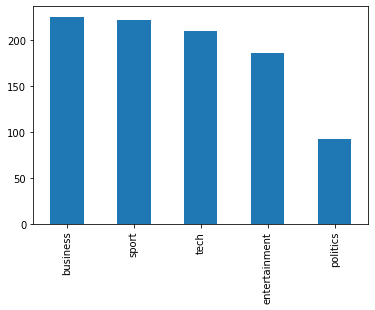

In [12]:
# Checking number of records of each label
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')


## Encode the labels into numeric

In [13]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,text,label
0,Quarterly profits at US media giant TimeWarn...,0
1,The dollar has hit its highest level against...,0
2,The owners of embattled Russian oil giant Yu...,0
3,British Airways has blamed high fuel prices ...,0
4,Shares in UK drinks and food firm Allied Dom...,0


In [14]:
# Perform preprocessing to text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [15]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.head()

,text,label
0,quarterly profits us media giant timewarner ju...,0
1,dollar hit highest level euro almost three mon...,0
2,owners embattled russian oil giant yukos ask b...,0
3,british airways blamed high fuel prices drop ...,0
4,shares uk drinks food firm allied domecq risen...,0


# Processing text for BERT model  -- Important

In [17]:
# transform the text to per 200 chars one array element
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:      # text.length > 150
        n = len(text1.split())//150     # get the text length // 150 's'  quotient
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200] # seperate per 200 one slot
            l_total.append(" ".join(l_parcial))
    return l_total



In [18]:
df['text_split'] = df['text'].apply(get_split)


In [26]:
df.head()['text_split'].shape

(5,)

##  Setting output directory for BERT


In [28]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
    try:
        tf.gfile.DeleteRecursively(OUTPUT_DIR)
#         tf.compat.v1.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


## Split into 80% training and 20% validation

In [29]:
train, val = train_test_split(df, test_size=0.2, random_state=35)
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label,text_split
0,bank england left interest rates hold sixth m...,0,[bank england left interest rates hold sixth m...
1,judge look david blunkett controversy key ques...,2,[judge look david blunkett controversy key que...


In [30]:
# Get labels
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4]

In [31]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label,text_split
0,remaining members rock band queen go tour next...,1,[remaining members rock band queen go tour nex...
1,paula radcliffe granted extra time decide whet...,3,[paula radcliffe granted extra time decide whe...


In [32]:
# Check shape of train and validation data
val.shape, train.shape

((187, 3), (748, 3))

In [43]:
val['text_split'][99]

['roman catholic organisations india demanded withdrawal film depicts priest affair girl half age indian television channels refusing run promotional material film sins ahead release friday director film vinod pande says movie offensive refused withdraw catholics planning protest mumbai bombay wednesday president one mumbais main catholic organisations dolphy dsouza says portrayal ordained priest man loose moral character hurt religious sentiments indias catholic community called film pornographic sensational mr dsouza also vicepresident catholics national body accused director film portraying priest bad light commercial gains catholics urged mr pande withdraw film show respect christian communitys hurt sentiments religion needs personal affair subject entertainment commercial use joseph dias general secretary catholic secular forum said statement mr pande said critics see film would protest would insist withdrawal says plans cancel film ahead scheduled screening friday forbidden love 

In [44]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(880, 880, 880)

In [48]:
train_l[0]

'bank england left interest rates hold sixth month row banks monetary policy committee mpc decided take action amid mixed signals economy economists predict rise cost borrowing come later year interest rates rose five times november august soaring house prices buoyant consumer data sparked inflation fears bank england governor mervyn king recently warned placing much weight one months economic data suggesting mpc waiting clearer picture emerge economists see next weeks inflation report mpc key assessing whether interest rate rise necessary keep economy check slower consumer spending quieter housing market likely convinced mpc rates left unchanged recent months inflation however rising faster expected hitting annual rate december highest level six months data wednesday also showed manufacturing output rose fastest rate since may last month reinforcing view economic growth stronger forecasts recent house surveys halifax nationwide indicated prices still rising albeit slower pace recent y

In [49]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
#len(val_l), len( val_label_l), len(val_index_l)
val_l[0] , val_label_l[0]


('remaining members rock band queen go tour next year former free bad company singer paul rodgers taking freddie mercurys place guitarist brian may said expects road rodgers drummer roger taylor april may said suddenly queen phoenix rising ashes take precedence lives queen played many different singers since mercurys death reportedly toured may performed rodgers concert celebrate th anniversary fender stratocaster guitar london september amazed chemistry going free hit right suddenly seems blindingly obvious something happening may wrote website teamed concert mark induction uk music hall fame joined taylor show went incredibly well point view got many rave reactions decided almost would look tour together may wrote queen went number one version rock sung boy band ive also played robbie williams young bob geldof queen bassist john deacon currently retired stage rodgers singer early s rockers free global hit right forming bad company successful supergroup members king crimson mott hoopl

## Getting train and validation set as dataframe

In [52]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,bank england left interest rates hold sixth mo...,0
1,judge look david blunkett controversy key ques...,2
2,us politicians proposing tough new law aimed c...,1
3,chelseas william gallas believes battle arsena...,3
4,investors snapped shares jet airways indias bi...,0


In [53]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,remaining members rock band queen go tour next...,1
1,paula radcliffe granted extra time decide whet...,3
2,five bank america subsidiaries agreed pay tota...,0
3,civil liberties group electronic frontier foun...,4
4,us poised push japan top supercomputing chart ...,4


# Fine tuning the BERT model

## The BERT model can be applied for any kind of classification task by fine-tuning it.

### 1. Preparing the input data, i.e create InputExample using the BERT’s constructor.
